# Semantic Segmentation with DeepLabV3

## CityScapes Dataset

[Repository](https://github.com/srihari-humbarwadi/DeepLabV3_Plus-Tensorflow2.0) | [Pre-trained Model](https://drive.google.com/file/d/1wRXyIGUVRws3BJHX-UrNDSZGDzUzgVMx/view) | [Dataset](https://www.cityscapes-dataset.com/)

## Setting Up Environment

In [1]:
# Clone Repo
!git clone --recursive https://github.com/srihari-humbarwadi/DeepLabV3_Plus-Tensorflow2.0; \
    rm -dr sample_data; \
    mv DeepLabV3_Plus-Tensorflow2.0/* .; \
    rm -drf DeepLabV3_Plus-Tensorflow2.0; \
    mkdir inferences

# Update Source Code
!sed -i 's/from tensorflow.python.keras.applications import keras_modules_injection/# from tensorflow.python.keras.applications import keras_modules_injection/g' resnet50.py
!sed -i 's/@keras_modules_injection/# @keras_modules_injection/g' resnet50.py
!awk '/from .imagenet_utils import _obtain_input_shape/ { print; print "from tensorflow import keras"; next }1' resnet/resnet50.py > tmp && mv tmp resnet/resnet50.py
!awk '/# Determine proper input shape/ { print; print "    keras_utils = keras.utils"; next }1' resnet/resnet50.py > tmp && mv tmp resnet/resnet50.py
!awk '/# Determine proper input shape/ { print; print "    models = keras.models"; next }1' resnet/resnet50.py > tmp && mv tmp resnet/resnet50.py
!awk '/# Determine proper input shape/ { print; print "    layers = keras.layers"; next }1' resnet/resnet50.py > tmp && mv tmp resnet/resnet50.py
!awk '/# Determine proper input shape/ { print; print "    backend = keras.backend"; next }1' resnet/resnet50.py > tmp && mv tmp resnet/resnet50.py

# Download Pretrained Model
!fileid="1wRXyIGUVRws3BJHX-UrNDSZGDzUzgVMx"; \
    filename="top_weights.h5"; \
    curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}" > /dev/null; \
    curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=${fileid}" -o ${filename}

Cloning into 'DeepLabV3_Plus-Tensorflow2.0'...
remote: Enumerating objects: 172, done.
remote: Total 172 (delta 0), reused 0 (delta 0), pack-reused 172
Receiving objects: 100% (172/172), 136.41 MiB | 7.64 MiB/s, done.
Resolving deltas: 100% (76/76), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    160      0 --:--:--  0:00:02 --:--:--   160
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 68.4M    0 68.4M    0     0  20.7M      0 --:--:--  0:00:03 --:--:-- 20.7M


## Reconstructing Model

In [2]:
import os
import pickle
import numpy as np
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

from deeplab import DeepLabV3Plus

In [3]:
# Instantiate Model
h, w = 800, 1600
with open('cityscapes_dict.pkl', 'rb') as f:
    id_to_color = pickle.load(f)['color_map']
model = DeepLabV3Plus(h, w, 34)
model.load_weights('top_weights.h5')

*** Building DeepLabv3Plus Network ***


/content/resnet/resnet50.py:270: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step
*** Output_Shape => (None, 800, 1600, 34) ***


## Making an Inference

Either upload an image or download it from a URL:

In [ ]:
# EITHER: Upload Image Input
from google.colab import files
files.upload()
# Don't forget to put the image into the inferences folder

In [4]:
# OR: Download Image Input
!imageurl="https://www.researchgate.net/profile/Varun_Jampani/publication/319056828/figure/fig3/AS:667765274845187@1536219056188/Qualitative-results-from-the-Cityscapes-dataset-Observe-how-NetWarp-PSPNet-is-able-to.jpg"; \
    filetype='jpg'; \
    curl ${imageurl} > inferences/input.${filetype}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67623  100 67623    0     0   249k      0 --:--:-- --:--:-- --:--:--  248k


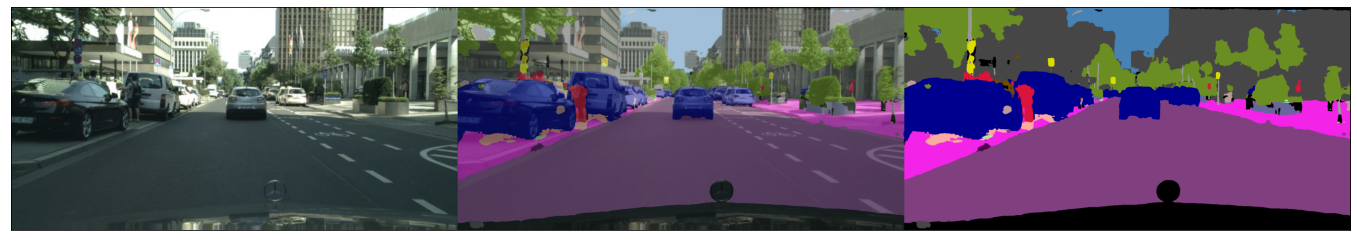

In [5]:
# Load Image
image_dir = 'inferences'
image_list = os.listdir(image_dir)
image_list.sort()
image = load_img(f'{image_dir}/{image_list[0]}')
image = img_to_array(image)

# Preprocess and Make Inference
image = cv2.resize(image, (w, h))
x = image.copy()
y = np.argmax(np.squeeze(
    model.predict(preprocess_input(np.expand_dims(x, axis=0)))), axis=2)

# Turn Inference to Image
img_color = image.copy()
for i in np.unique(y):
    if i in id_to_color:
        img_color[y == i] = id_to_color[i]
disp = img_color.copy()

# Visualise Inference
alpha = 0.5
cv2.addWeighted(image, alpha, img_color, 1 - alpha, 0, img_color)
out = np.concatenate([image/255, img_color/255, disp/255], axis=1)
plt.figure(figsize=(24, 12))
plt.xticks([])
plt.yticks([])
plt.imshow(img_color/255.0)
plt.imshow(out)

## Interpreting the Inference

[cityscapesScripts](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)

In [10]:
# Metadata from cityscapesScripts

from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [45]:
counts = np.unique(y, return_counts=True)
total  = y.size

print([idx for idx, val in enumerate(counts[0]) if val == 1])

for label in labels:
    label_idx   = label.id

    counter_idx = None
    for idx, val in enumerate(counts[0]):
        if val == label_idx:
            counter_idx = idx

    if counter_idx:
        percentage = 100 * counts[1][counter_idx] / total
        print(f'{percentage:>10.5f}% {label.name}')

[0]
   3.38953% rectification border
   0.18695% out of roi
   0.58586% static
   0.12172% dynamic
   0.06227% ground
  36.35242% road
   5.17687% sidewalk
   0.55500% parking
  20.88320% building
   0.47016% wall
   0.22906% fence
   0.00008% bridge
   0.36516% pole
   0.31266% traffic sign
  10.82234% vegetation
   0.04336% terrain
   3.56609% sky
   0.68305% person
  10.17953% car
   0.00047% truck
   0.00258% bicycle


Developed by the City Intelligence Lab, Austrian Institute of Technology GmbH